In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from montlake.plotting.manifolds import plot_manifold_2d, plot_manifold_3d,plot_manifold_featurespace
from montlake.plotting.plotting import plot_cosines, get_cmap,get_names, plot_cosines_cluster
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm,plot_watch_custom, plot_watch,plot_cos_boxes
import dill as pickle
import pathos
from montlake.utils.utils import data_stream_custom_range, cosine_similarity
from pathos.multiprocessing import ProcessingPool as Pool
from montlake.atomgeom.features import get_features
from montlake.utils.utils import get_atoms4_full, get_index_matching, get_cosines
from montlake.utils.replicates import get_detected_values2d
import numpy as np
import itertools
import seaborn as sns
from matplotlib.patches import Rectangle

# export
import numpy as np
import random
import argparse
import json
import sys
import scipy
from montlake.vendor.tfcompat.hparam import HParams
import os
import dill as pickle

random.seed(1234)

config = {}
with open('/Users/samsonkoelle/tunatostada/experiments/configs_plotting/eth_diagram_mf.json') as f:
    config.update(json.load(f))

hparams = HParams(**config)
if not os.path.exists(hparams.outdir):
    os.makedirs(hparams.outdir)

positions = np.load(hparams.position_file)
for key in hparams.ground_truth.keys():
    if hparams.ground_truth[key] is None:
        hparams.ground_truth[key] = np.asarray([])
    hparams.ground_truth[key] = np.asarray(hparams.ground_truth[key], dtype = int)

print('plotting',hparams.ground_truth)
#if not hparams.color_counts_all:
#    hparams.color_counts_all = None

plotting {'atoms4': array([[6, 1, 0, 2],
       [1, 0, 2, 8]]), 'atoms3': array([], dtype=int64), 'atoms2': array([], dtype=int64)}


In [2]:
result_file = hparams.result_file
positions = positions
d = hparams.d
name = hparams.name
ncord = hparams.ncord
embedding = hparams.embedding
ground_truth = hparams.ground_truth
colors_gt = hparams.ground_truth_colors
outdir = hparams.outdir
color_counts_all = hparams.color_counts_all
colors_id_all = hparams.colors_id_all
n_components = hparams.n_components
ptsize = hparams.ptsize
alpha = hparams.alpha
gt_reg_color = hparams.gt_reg_color
sel_reg_color = hparams.sel_reg_color
plot_watch_full = hparams.plot_watch_full
plot_watch_results = hparams.plot_watch_results
cosine_color = hparams.cosine_color
selected_cosines = hparams.selected_cosines
cosine_cluster = hparams.cosine_cluster
names_gt = None

In [11]:
hparams.selected_cosines

True

loading data
compute ground truth values for comparison
getting ground truth names
cca [9, 3]
getting all colors
getting colors and names of selected functions
plotting top coordinates in feature space
0
1
2
3
4
5
plotting sample regularization path
plotting watches
plotting full cosine matrix colored (12, 12)
plotting cosines of ground truth and selected lasso


ValueError: setting an array element with a sequence.

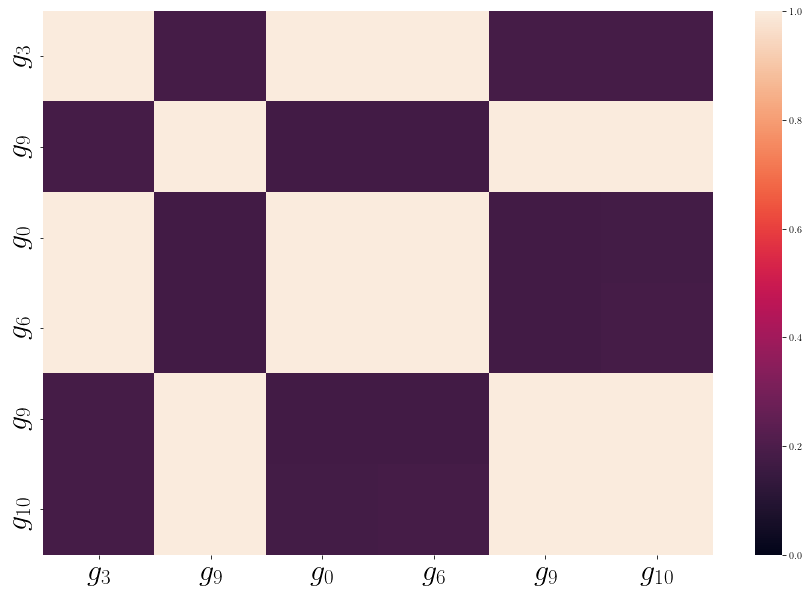

In [10]:

print('loading data')
with open(result_file,'rb') as inp:
    results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)

atoms4 = results['dictionary']['atoms4']

p = results['replicates_small'][0].dg_M.shape[2]
nreps = results['supports_lasso'][1].shape[0]
embed = results['embed']

if ground_truth is not None:
    print('compute ground truth values for comparison' )
    cores = pathos.multiprocessing.cpu_count() - 1
    pool = Pool(cores) 
    n = positions.shape[0]
    gt_results = pool.map(lambda i: get_features(positions[i],
                               atoms2 = ground_truth['atoms2'],
                               atoms3 = ground_truth['atoms3'],
                               atoms4 = ground_truth['atoms4']),
        data_stream_custom_range(list(range(n))))
    values_gt = np.vstack([np.hstack(gt_results[i]) for i in range(n)])

print('getting ground truth names')
if names_gt is None and ground_truth is not None:
    natoms = positions.shape[1]
    #atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4))) 
    superset = results['dictionary']['atoms4']#get_atoms4_full(atoms4) #needs adjustment for diagram dictionaries
    if d == 2:
        j1 = get_index_matching(ground_truth['atoms4'][0], superset) #needs adjustment for non torsion ground truths
        j2 = get_index_matching(ground_truth['atoms4'][1], superset)
        gt_ind = [j1,j2]
        names_gt = get_names(np.asarray(gt_ind))
    if d ==1:
        j1 = get_index_matching(ground_truth['atoms4'][0], superset)
        gt_ind = [j1]
        names_gt = get_names(np.asarray(gt_ind))

# if ground_truth is not None:
#     print('plotting ground truth function values')
#     for k in range(len(gt_ind)):
#         title = names_gt[k] +' ' +  str(atoms4[gt_ind[k]] + 1)
#         if n_components == 3:
#             plot_manifold_3d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])#, title_color = colors[s])  
#         if n_components == 2:
#             plot_manifold_2d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])

if ground_truth is None:
    gt_ind = []
    colors_gt = np.empty((0,4), int)

print('cca', color_counts_all)
if color_counts_all is not None:
    print('getting all colors')
    colors_all = np.empty((0,4), int)
    for c in range(len(color_counts_all)):
        colors_all = np.vstack([colors_all, np.repeat([colors_id_all[c]], color_counts_all[c], axis = 0)])

print('getting colors and names of selected functions')
selected_lasso = results['selected_lasso']
colors_lasso = get_cmap(selected_lasso)
names_lasso = get_names(selected_lasso)
selected_ts = results['selected_ts']
colors_ts = get_cmap(selected_ts)
names_ts = get_names(selected_ts)
colors_lasso_full = np.zeros((p,4))
colors_lasso_full[selected_lasso] = colors_lasso
colors_ts_full = np.zeros((p,4))
colors_ts_full[selected_ts] = colors_ts

print('plotting top coordinates in feature space')
data = results['data']
title = name + ' top PCA'
plot_manifold_featurespace(data,title,ncord)    
plt.savefig(outdir + '/features')
plt.close()

print('plotting sample regularization path')
if gt_reg_color:
    fig, axes_all = plt.subplots(figsize=(15, 10))
    #colors = np.zeros((p,4))
    #colors[subset_l0_plusgt] = colors_l0_plusgt
    plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors_all)#axes_all[0].imshow(asdf)
    axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
    axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
    axes_all.set_xticklabels([])
    plt.tight_layout()
    plt.savefig(outdir + '/reg_path_gt')
    plt.close()

if sel_reg_color:
    fig, axes_all = plt.subplots(figsize=(15, 10))
    plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors_lasso_full)#axes_all[0].imshow(asdf)
    axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
    axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
    axes_all.set_xticklabels([])
    plt.tight_layout()
    plt.savefig(outdir + '/reg_path_sel')
    plt.close()

# if embedding:
#     supports_lasso_values = np.vstack([np.hstack(results['supports_lasso_values'][i]) for i in range(n)])
#     supports_ts_values = np.vstack([np.hstack(results['supports_ts_values'][i]) for i in range(n)])
#     print('plotting selected function values', colors_ts.shape, supports_ts_values.shape)
#     #for s in range(len(results['selected_lasso'])):
#     for s in range(supports_lasso_values.shape[1]):
#         c = supports_lasso_values[:,s]
#         title_color = colors_lasso[s]
#         title = names_lasso[s] + ' ' + str(atoms4[selected_lasso[s]] + 1)

#         if n_components == 3:
#             plot_manifold_3d(embed, ptsize, alpha, c, title,title_color = title_color)#, title_color = colors[s])  
#         if n_components == 2:
#             plot_manifold_2d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors[s])
#         plt.savefig(outdir + '/selected_function_lasso_'+ str(s))
#         plt.close()
#     #for s in range(len(results['selected_ts'])):
#     for s in range(supports_ts_values.shape[1]):
#         title_color = colors_ts[s]
#         title = names_ts[s] + ' ' + str(atoms4[selected_ts[s]] + 1)
#         c = supports_ts_values[:,s]
#         if n_components == 3:
#             plot_manifold_3d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors_ts[s])  
#         if n_components == 2:
#             plot_manifold_2d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors_ts[s])   
#         plt.savefig(outdir + '/selected_function_ts_' + str(s))
#         plt.close()

if name_counts_all is None:
    names_all = list(range(p))
else:
    names_all = np.asarray(list([]), dtype =str)
    for i in range(len(name_counts_all)):
        for j in range(name_counts_all[i]):
            names_all = np.hstack([names_all,(str(i+1) + ',' + str(j+1))])     

print("plotting watches")
if plot_watch_full:
    p = results['supports_lasso'][0].shape[0]
    #print(results['supports_lasso'][0].shape, p,colors_all.shape)
    fig, axes_all = plt.subplots(figsize=(15, 10))
    plot_watch_custom(results['supports_lasso'][0], p, axes_all,colors_all, nreps, names_all)
    plt.savefig(outdir + '/watch_full')
    plt.close()


if plot_watch_results:
    sub = results['supports_lasso'][0]
    for w in range(len(results['supports_lasso'][0].shape)):
        sub = np.take(sub, selected_lasso, axis = w)
    fig, axes_all = plt.subplots(figsize=(15, 10))
    plot_watch(sub, names=names_lasso, ax = axes_all,colors = colors_lasso, nreps = nreps) 
    axes_all.set_title('Estimated Support', fontsize = 40)
    plt.tight_layout()
    plt.savefig(outdir + '/watch_lasso')
    plt.close()

    sub = results['supports_ts'][0]
    for w in range(len(results['supports_ts'][0].shape)):
        sub = np.take(sub, selected_ts, axis = w)      
    fig, axes_all = plt.subplots(figsize=(15, 10))
    plot_watch(sub, names=names_ts, ax = axes_all,colors = colors_ts, nreps = nreps) 
    axes_all.set_title('Estimated Support', fontsize = 40)
    plt.tight_layout()
    plt.savefig(outdir + '/watch_ts')
    plt.close()

if d > 1:
    if cosine_color:
        cosines_full= results['replicates_small'][0].cosine_abs
        print("plotting full cosine matrix colored",cosines_full.shape)
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_cosines(cosines_full, axes_all, colors_all, names_all) 
        plt.tight_layout()
        plt.savefig(outdir + '/cosine_colored')
        plt.close()

    if cosine_cluster:
        print("plotting full cosine matrix clustered")
        cosines_full= results['replicates_small'][0].cosine_abs
        plot_cosines_cluster(cosines_full)
        plt.savefig(outdir + '/cosines_clustered')
        plt.close()

    if selected_cosines:
        print("plotting cosines of ground truth and selected lasso")
        selected_lasso_gt = np.concatenate((gt_ind, selected_lasso)) #add 234
        colors_lasso_plusgt = np.vstack([colors_gt, colors_lasso])
        names_lasso_plusgt = np.concatenate((names_gt, names_lasso))
        cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_lasso_gt]))
        cuz_l0 = np.mean(cuz_l, axis = 0)
        fig, axarr = plt.subplots(figsize=(15, 10))
        plot_cos_boxes(results['supports_lasso'][1], names_lasso_plusgt, cuz_l0, selected_lasso_gt, d , nreps,axarr)
        for xtick, color in zip(axarr.get_xticklabels(), colors_lasso_plusgt):
            xtick.set_color(color)
        for ytick, color in zip(axarr.get_yticklabels(), colors_lasso_plusgt):
            ytick.set_color(color)
        axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                        fontsize = 30)
        plt.tight_layout()
        plt.yticks(rotation= 0)
        plt.savefig(outdir + '/cosines_sellasso_gt')
        plt.close()

        print("plotting cosines of ground truth and selected ts")
        selected_ts_gt = np.concatenate((gt_ind, selected_ts)) #add 234
        colors_ts_plusgt = np.vstack([colors_gt, colors_ts])
        names_ts_plusgt = np.concatenate((names_gt, names_ts))
        cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_ts_gt]))
        cuz_l0 = np.mean(cuz_l, axis = 0)
        fig, axarr = plt.subplots(figsize=(15, 10))
        plot_cos_boxes(results['supports_ts'][1], names_ts_plusgt, cuz_l0, selected_ts_gt, d , nreps,axarr)
        for xtick, color in zip(axarr.get_xticklabels(), colors_ts_plusgt):
            xtick.set_color(color)
        for ytick, color in zip(axarr.get_yticklabels(), colors_ts_plusgt):
            ytick.set_color(color)
        axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                        fontsize = 30)
        plt.tight_layout()
        plt.yticks(rotation= 0)   
        plt.savefig(outdir + '/cosines_selts_gt')
        plt.close()



In [13]:
print("getting correlations with ground truth")
coses = np.zeros((nreps,d,d))
for r in range(nreps):
    print(r)
    j3 = results['supports_lasso'][1][r,0]
    j4 = results['supports_lasso'][1][r,1]

    rep = results['replicates_small'][0]
    nsel = rep.dg_M.shape[0]
    coses[r,0,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,0,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
    coses[r,1,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,1,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
    #pd.save('save')

coses_i = np.zeros((nreps,2))
for r in range(nreps):
    mean1 = np.mean([coses[r, 0,1], coses[r, 1,0]])
    mean2 = np.mean([coses[r, 0,0], coses[r, 1,1]])
    betterpair = np.argmax([ mean1,mean2])
    if betterpair == 0:
        coses_i[r] = [coses[r, 0,1], coses[r, 1,0]]
    else:
        coses_i[r] = [coses[r, 1,1], coses[r, 0,0]]

print('lasso matched cos mean',np.mean(coses_i))
print('lasso matched cos var', np.var(coses_i)**(0.5))
print("getting correlations with ground truth")
coses = np.zeros((nreps,d,d))

for r in range(nreps):
    print(r)
    j3 = results['supports_ts'][1][r,0]
    j4 = results['supports_ts'][1][r,1]

    rep = results['replicates_small'][0]
    nsel = rep.dg_M.shape[0]
    coses[r,0,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,0,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
    coses[r,1,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
    coses[r,1,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel

coses_i = np.zeros((nreps,2))
for r in range(nreps):
    mean1 = np.mean([coses[r, 0,1], coses[r, 1,0]])
    mean2 = np.mean([coses[r, 0,0], coses[r, 1,1]])
    betterpair = np.argmax([ mean1,mean2])
    if betterpair == 0:
        coses_i[r] = [coses[r, 0,1], coses[r, 1,0]]
    else:
        coses_i[r] = [coses[r, 1,1], coses[r, 0,0]]

print('ts matched cos mean',np.mean(coses_i))
print('ts matched cos var', np.var(coses_i)**(0.5))

getting correlations with ground truth
0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

plotting full cosine matrix colored (12, 12)


NameError: name 'ax' is not defined

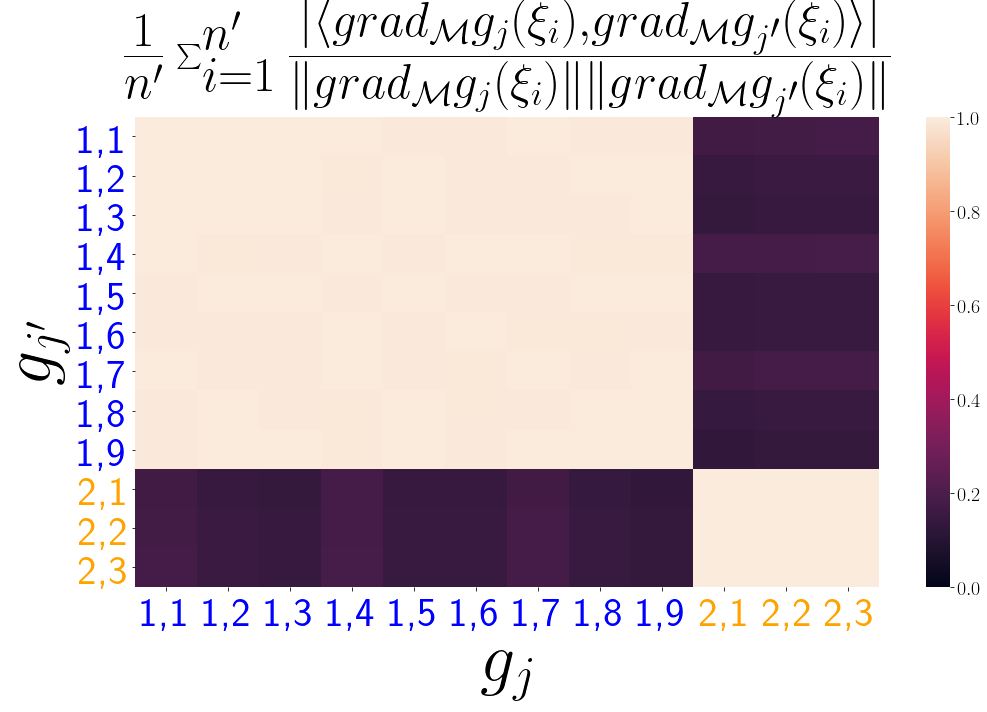

In [16]:
cosines_full= results['replicates_small'][0].cosine_abs
print("plotting full cosine matrix colored",cosines_full.shape)
fig, axes_all = plt.subplots(figsize=(15, 10))
plot_cosines(cosines_full, axes_all, colors_all, names_all) 
plt.tight_layout()
cosines = cosines_full
p = cosines.shape[0]
sns.heatmap(cosines, ax=ax, vmin=0., vmax=1.)
#    ax = sns.heatmap(x, cmap=cmap)
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

for xtick, color in zip(ax.get_xticklabels(), colors):
    xtick.set_color(color)
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
#ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=500 / p)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=500 / p)
ax.set_xticklabels(names, fontsize=500 / p)
#ax.set_yticklabels(names, fontsize=500 / p, rotation = 90)
ax.set_yticklabels(names, fontsize=500 / p, rotation = 0)

ax.set_ylabel(r"$g_{j'}$", fontsize=70)
ax.set_xlabel(r"$g_{j}$", fontsize=70)
# ax.set_title(r"$\text{hi}$")
ax.set_title(
    r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{ |\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|}$",
    fontsize=70)